# Da li znanje matematike ima veze sa znanjem programiranja

U fajlu "studenti.csv" je dataset sa podacima više studenata (svaki red je jedan student) i kolonama:
- Indeks (broj indeksa - anonimizirano)
- Ime, Prezime (anonimizirano)
- Pol
- Matematika 1 (broj poena na ispitu iz matematike)
- Principi programiranja (broj poena na ispitu iz programiranja)

Potrebno je utvrditi da li postoje neke grupe studenata kada se analiziraju ocene iz matematike i programiranja.
Subjektivne pretpostavke su da studenti koji znaju matematiku, znaju dobro i da programiraju. Ne uzimati u obzir
pol studenata pri klasterizaciji.

Probati sa KMeans klasterizacijom.

Kojem klasteru bi pripao student koji ima 50 poena iz matematike i 100 iz programiranja?

Napomene:
- Ovo je "idealan" primer, ali su podaci stvarni
- Nema nedostajućih podataka
- Nema outlier-a
- Radi se analiza samo prema dve promenljive (broj poena iz matematike i programiranja)
- Obe promenljive su u istom rasponu od 40 do 100

In [1]:
#Učitavanje pandas-a (rad sa dataframe-ovima), sklearn.cluster (klasterovanje) i matplotlib-a (grafici)
import pandas as pd
import sklearn.cluster as cluster
import matplotlib.pyplot as plt

In [4]:
#Učitavanje podataka iz csv fajla u Pandas Data Frame
studenti = pd.read_csv("../data/studenti.csv")

#Pogledamo otprilike koji su podaci
studenti.head()

,Indeks,Ime,Prezime,Pol,Matematika 1,Principi programiranja
0,1,**,**,M,61,60
1,2,**,**,Z,84,93
2,3,**,**,M,79,93
3,4,**,**,M,42,44
4,5,**,**,M,43,41


In [5]:
#Pogledamo i detaljnije kog su tipa, kao i koje su deskriptivne statistike za numeričke podatke
studenti.info()
studenti.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Indeks                  100 non-null    int64 
 1   Ime                     100 non-null    object
 2   Prezime                 100 non-null    object
 3   Pol                     100 non-null    object
 4   Matematika 1            100 non-null    int64 
 5   Principi programiranja  100 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 4.8+ KB


,Indeks,Matematika 1,Principi programiranja
count,100.000000,100.000000,100.000000
mean,50.500000,62.840000,62.920000
std,29.011492,14.669228,15.970098
min,1.000000,41.000000,41.000000
25%,25.750000,50.500000,48.750000
50%,50.500000,62.000000,61.000000
75%,75.250000,76.000000,77.250000
max,100.000000,100.000000,95.000000


In [7]:
#Izbacivanje promenljivih tj. kolona "Indeks", "Pol" "Ime" i "Prezime" jer nisu potrebni u dataset-u
# Indeks, ime i prezime su opisni, a rečeno je da pol treba izuzeti iz klasterizacije.
#Ostaju samo numeričke promenljive po kojima će se vršiti klasterovanje
cluster_data = studenti.drop(columns = ["Indeks", "Pol", "Ime", "Prezime"])

In [8]:
# Ovde proverimo NAs u svim kolonama (promenljivima)
# Nema NaN vrednosti ni u jednoj koloni
print(cluster_data.isnull().sum())

Matematika 1              0
Principi programiranja    0
dtype: int64


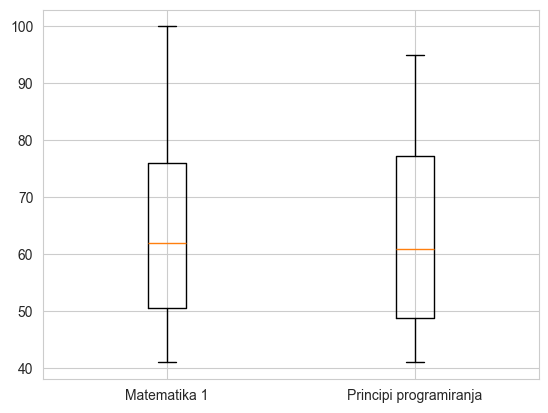

In [9]:
# Proveravamo outlier-e preko box plot-a
plt.boxplot(cluster_data[["Matematika 1", "Principi programiranja"]], tick_labels=["Matematika 1", "Principi programiranja"])
plt.show()
# Nema outlier-a (tačke iznad ili ispod na box-plot-u)

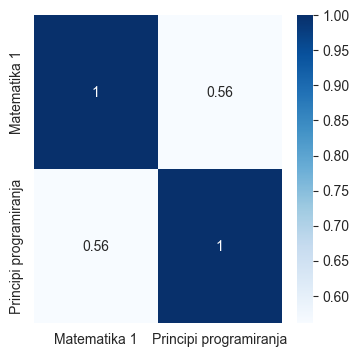

,Matematika 1,Principi programiranja
Matematika 1,1.000000,0.560813
Principi programiranja,0.560813,1.000000


In [10]:
# Proveravamo da li postoji korelacija između ove dve promenljive
# Nekakva korelacija postoji, ali nije prevelika (0.56) pa ne izbacujemo ništa
import seaborn as sb

# Proveravamo korelacije preostalih promenljivih
plt.figure(figsize=(4,4))
sb.heatmap(cluster_data.corr(), cmap="Blues",annot=True)
plt.show()

# Ili alternativno pogledamo korelacije samo kao tabelu ako nema previše kolona
cluster_data.corr()

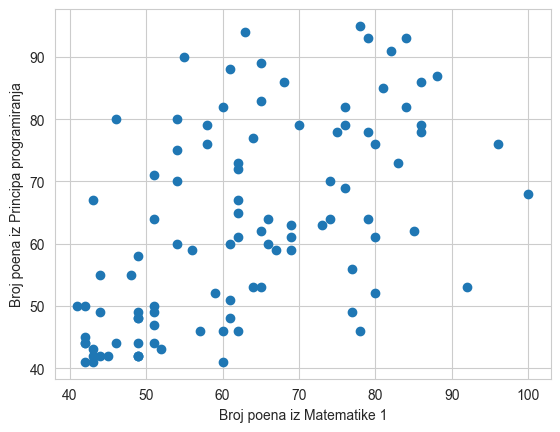

In [11]:
#Pošto su samo dve promenljive, možemo da nacrtamo scatterplot da vidimo raspodelu
#Konkretno, da vidimo da li se uočavaju klasteri golim okom
plt.scatter(cluster_data["Matematika 1"], cluster_data["Principi programiranja"])
plt.xlabel("Broj poena iz Matematike 1")
plt.ylabel("Broj poena iz Principa programiranja")

plt.show()

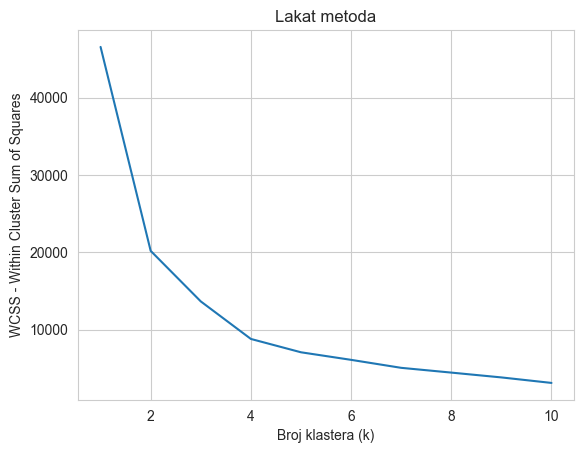

In [12]:
# Pošto nismo sigurni koliki je optimalan broj klastera, probamo elbow metodu
# tako što uradimo klasterizaciju za npr 1 do 10 klastera preko kmeans++ metode
# i izračunamo grešku WCSS (Within cluster sum of squares) suma kvadrata unutar
# klastera za svaku varijantu 1-10

# lista sa greškama
wcss = []

# Petlja od 1 do 10 klastera
for i in range(1, 11):
    kmeans = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    # Metoda fit() vrši klasterizaciju
    kmeans.fit(cluster_data)
    # Dodavanje greške (kmeans.inertia_) u listu
    wcss.append(kmeans.inertia_)

# Crtanje grafika sa prikazanom greškom za svaku od varijanti 1-10 klastera
# Čini se da je najbolje 2 ili 4 klastera
plt.plot(range(1, 11), wcss)
plt.title('Lakat metoda')
plt.xlabel('Broj klastera (k)')
plt.ylabel('WCSS - Within Cluster Sum of Squares')
plt.show()

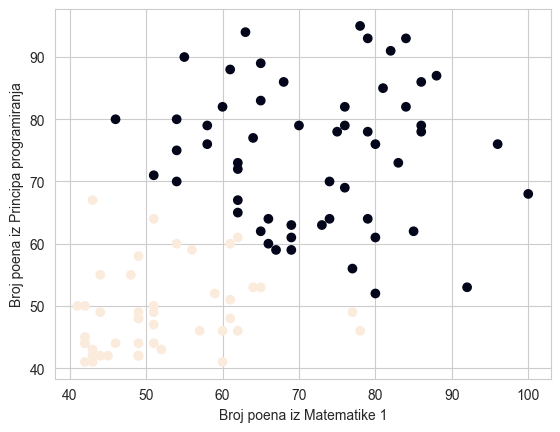

Veličina klastera 1: 55
Veličina klastera 2: 45


In [15]:
# Probamo sa dva klastera, kmeans++
kmeans = cluster.KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=1000, random_state=0).fit(cluster_data)

# Metoda fit() vrši klasterizaciju
# Metoda predict() vrši svrstavanje nove instance u postojeće klastere

# Opet scatter plot sa bojama koje označavaju koji student pripada kojem klasteru
plt.scatter(cluster_data["Matematika 1"], cluster_data["Principi programiranja"], c=kmeans.labels_)
plt.xlabel("Broj poena iz Matematike 1")
plt.ylabel("Broj poena iz Principa programiranja")
plt.show()

# Novi Data frame sa podacima i dodatom kolonom sa oznakama klastera
two_clusters = cluster_data.copy()

# Niz koji sadrži podake kom klasteru pripada koji student (red
# u data frame-u) se dobija preko kmeans.labels_ pa ga dodajemo kao novu kolonu
two_clusters["cluster"] = kmeans.labels_

# Subjektivna procena: previše su opšti klasteri, izdvojila se grupa studenata kojima
#ide loše i matematika i programiranje, i grupa koju čine svi ostali.
# Objektivna procena:
# 1. Klasteri imaju značajnu veličinu (55, 45)
print("Veličina klastera 1:", two_clusters.loc[two_clusters["cluster"] == 0, "cluster"].count())
print("Veličina klastera 2:", two_clusters.loc[two_clusters["cluster"] == 1, "cluster"].count())

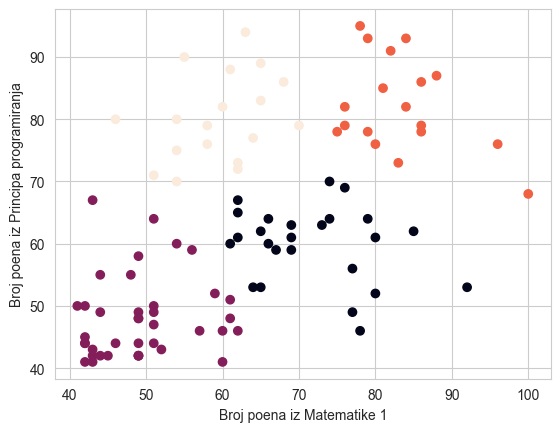

Veličina klastera 1: 25
Veličina klastera 2: 39
Veličina klastera 3: 18
Veličina klastera 4: 18


In [16]:
# Probamo sa četiri klastera kmeans++
kmeans = cluster.KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=1000, random_state=0).fit(cluster_data)

plt.scatter(cluster_data["Matematika 1"], cluster_data["Principi programiranja"] ,c=kmeans.labels_)
plt.xlabel("Broj poena iz Matematike 1")
plt.ylabel("Broj poena iz Principa programiranja")
plt.show()

# Novi data frame sa podacima i kolonom sa oznakama klastera
four_clusters = cluster_data
four_clusters["cluster"] = kmeans.labels_

# Subjektivna procena: Možda najsmislenije
# 1. Studenti kojima ne ide nijedno
# 2. Studenti kojima idu oba odlično
# 3. Studenti kojima ide matematika, ali im ne ide programiranje
# 4. Studenti kojima odlično ide programiranje ali im ne ide matematika
# Objektivna procena:
# 1. Klasteri imaju značajnu veličinu (25, 39, 18, 18)
print("Veličina klastera 1:", four_clusters.loc[cluster_data["cluster"] == 0, "cluster"].count())
print("Veličina klastera 2:", four_clusters.loc[cluster_data["cluster"] == 1, "cluster"].count())
print("Veličina klastera 3:", four_clusters.loc[cluster_data["cluster"] == 2, "cluster"].count())
print("Veličina klastera 4:", four_clusters.loc[cluster_data["cluster"] == 3, "cluster"].count())



In [18]:
four_clusters

,Matematika 1,Principi programiranja,cluster
0,61,60,0
1,84,93,2
2,79,93,2
3,42,44,1
4,43,41,1
...,...,...,...
95,51,47,1
96,68,86,3
97,61,48,1
98,54,70,3


In [17]:
# Napravimo nova 4 data frame-a gde odvojimo podatke za svaki klaster
cluster1 = four_clusters.loc[four_clusters["cluster"] == 0, ["Matematika 1", "Principi programiranja"]]
cluster2 = four_clusters.loc[four_clusters["cluster"] == 1, ["Matematika 1", "Principi programiranja"]]
cluster3 = four_clusters.loc[four_clusters["cluster"] == 2, ["Matematika 1", "Principi programiranja"]]
cluster4 = four_clusters.loc[four_clusters["cluster"] == 3, ["Matematika 1", "Principi programiranja"]]

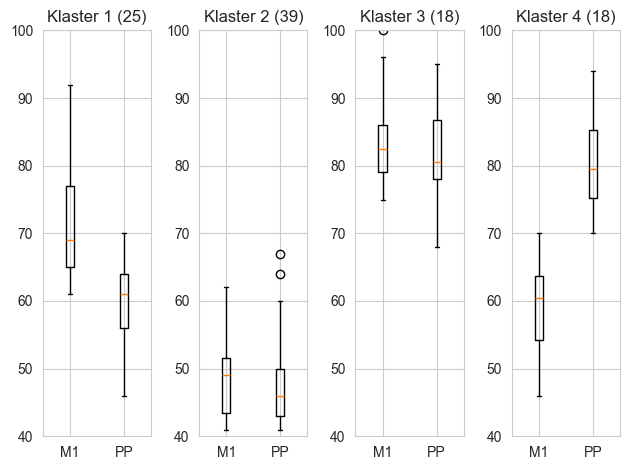

In [19]:
# Pravimo 4 boxplot-a na kojima vidimo ta četiri klastera i raspodele poena unutra njih
fig, ax = plt.subplots(1,4)

ax[0].boxplot(cluster1, tick_labels=("M1", "PP"))
ax[0].set_ylim(40, 100)
ax[0].set_title("Klaster 1 (25)")

ax[1].boxplot(cluster2, tick_labels=("M1", "PP"))
ax[1].set_ylim(40, 100)
ax[1].set_title("Klaster 2 (39)")

ax[2].boxplot(cluster3, tick_labels=("M1", "PP"))
ax[2].set_ylim(40, 100)
ax[2].set_title("Klaster 3 (18)")

ax[3].boxplot(cluster4, tick_labels=("M1", "PP"))
ax[3].set_ylim(40, 100)
ax[3].set_title("Klaster 4 (18)")

plt.tight_layout()
plt.show()

In [ ]:
# Tumačenje klastera

# 1. Veličina klastera
# Veličine klastera su 25, 39, 18 i 18 respektivno, tako da svaki klaster ima značajnu veličinu,
# sa tim da je klaster 2 (studenti kojima ništa ne ide) najveći.

# 2. Centri klastera
# Klaster 1 čine studenti kojima ok ide matematika, ali im slabije ide programiranje
# Klaster 2 čine studenti kojima ne ide nijedno (ili su odustali od studija)
# Klaster 3 čine studenti kojima idu oba odlično
# Klaster 4 čine studenti kojima odlično ide programiranje ali im slabo ide matematika

# 3. Disperzija od centara
# Klaster 1 je najmanje homogen (najveća disperzija) po atributu Matematika 1 dok su ostali
# klasteri više homogeni. Disperzija po atributu Principi programiranja je najveća za klaster 3,
# a najmanja za klaster 2.
# Uopšteno gledano, čini se da je najhomogeniji klaster 2 kojeg čine studenti kojima ne ide
# ni matematika ni programiranje.

In [20]:
# A sada, kojem klasteru bi pripao student koji ima 50 poena iz matematike i 100 iz programiranja?
novi_student = pd.DataFrame({'Matematika 1': [50],
        'Principi programiranja': [100]})

# Metoda predict() koju pozivamo nad treniranim modelom (kmeans promenljiva) i prosleđujemo joj novog studenta
# kao datafreame (može i više studenata odjednom)
print ("Nov student najviše pripada klasteru : ",  kmeans.predict(novi_student)[0]+1)


Nov student najviše pripada klasteru :  4
